# CS1090A Final Project
#### Group 71: Gulirano Almuratova, Eva Pierre Antoine, Victoria Levy, Linh Vu, Binh Vu
#### Project 43: Predicting US Health Insurance Premiums

## PART I. Introduction
### Finalized Research Question
Healthcare in the United States is a highly controversial topic, affecting millions of Americans every day. Coverage and costs vary widely based on many factors, including insurance plans, medical history, occupations, and demographic characteristics. 

Our project aims to classify the cost of yearly private insurance premiums as low, medium, or high. We categorize premiums into three groups: **low** (individuals who pay nothing for insurance or don't purchase insurance, i.e., `HIPCOST` = 0), **medium** (those who pay less than `$7,000` annually, a threshold derived from the Affordable Care Act’s definition of affordability as 9\% of \$80,000, the median U.S. income), and **high** (those who pay more than `$7,000` annually). By framing the problem as a classification task, we aim to provide insights into the factors influencing healthcare affordability and premium costs.

### Data Description
Our project utilizes data from the 2022 National Health Interview Survey (NHIS), a comprehensive dataset collected annually by the National Center for Health Statistics. This dataset allows us capture various aspects of Americans’ health, healthcare access, and insurance coverage. The NHIS uses a stratified multistage probability sampling approach, ensuring representation across diverse demographic and socioeconomic groups. 

The dataset includes detailed information on individuals’ healthcare plans, personal demographics, health status, and social factors. For our project, we chose only relevant variables including demographic characteristics (e.g., age, gender, race, and education level), health ratings, and lifestyle factors such as marital and employment status. We filtered the data to only include 18+ individuals and those with private health insurance.

### Data Preparation
With a new dataset from our previous milestone, we began by cleaning and reformatting categorical variables, translating numerical codes into meaningful descriptors (e.g., yearly doctor visits, gender, health rating, education, race, region, and marital status). Binary variables, such as military service, citizenship, and employment status, were standardized to 0 and 1 values. 

To address missing data, we excluded rows lacking definitive healthcare premium information (e.g., missing, unknown, or refused responses). We decided against imputing values for this as it is our predictor variable; it seemed counterintuitive to predict a value to impute and then use our model to then predict that value again. 

Additionally, we had to recode certain variables due to the differences in universes. For example, those who did not smoke were not asked how often they smoked. In such cases, we recoded the NaNs to a 0. 

In [22]:
# pip install lime
# pip install shap

In [23]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
                            roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

# import lime
# from lime.lime_tabular import LimeTabularExplainer

import warnings
# Suppress specific sklearn UserWarning about feature names
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [24]:
# For calculating total notebook runtime
notebook_start = time.time()

In [25]:
# load data
cleaned_df = pd.read_csv("cleaned_df2022.csv")

In [26]:
# drop var with lots of NAs
cols_to_keep = ['AGE', 'BMICALC',
                       'MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY',
                       'GOTWELF', 'DEMENTIAEV', 'CITIZEN','HIPCOST']
df = cleaned_df[cols_to_keep].dropna()

In [27]:
# recode into Low, Medium, High categories
t1 = 1
t2 = 7000
df['HIPCOST'] = pd.cut(df['HIPCOST'],
                       bins=[0,t1,t2,50000],
                       labels=['Low','Medium','High'],
                       include_lowest=True).astype(str)

# check for balance
df['HIPCOST'].value_counts()

HIPCOST
Medium    7621
Low       2912
High      1472
Name: count, dtype: int64

### EDA of Variables Chosen for Model
After we did our initital EDA, we reduced the number of variables we would be using in our final classification model. These variables include `age`, `BMI`, `marital status`, `region`, `last doctors visit`, `frequency of smoking`, `race`, `education`, `poverty level`, if they receive `welfare`, if they have `dementia`, as well as `citizenship status`. 

This refined list represents a combination of factors that, based on our analysis, are likely to provide the most predictive power while ensuring interpretability. We can highlight some preliminary insights here. The plot for `SMOKFREQNOW` shows that non-smokers tend to pay lower premiums. Cost also varies for different `marital status` groups; divorced people tend to pay more than never married people, for example. And the `CITIZEN` plot shows that citizens are more likely to pay high and medium insurance premiums.

From here, we wanted to look at the spread of each of these variables to investigate the relationships.

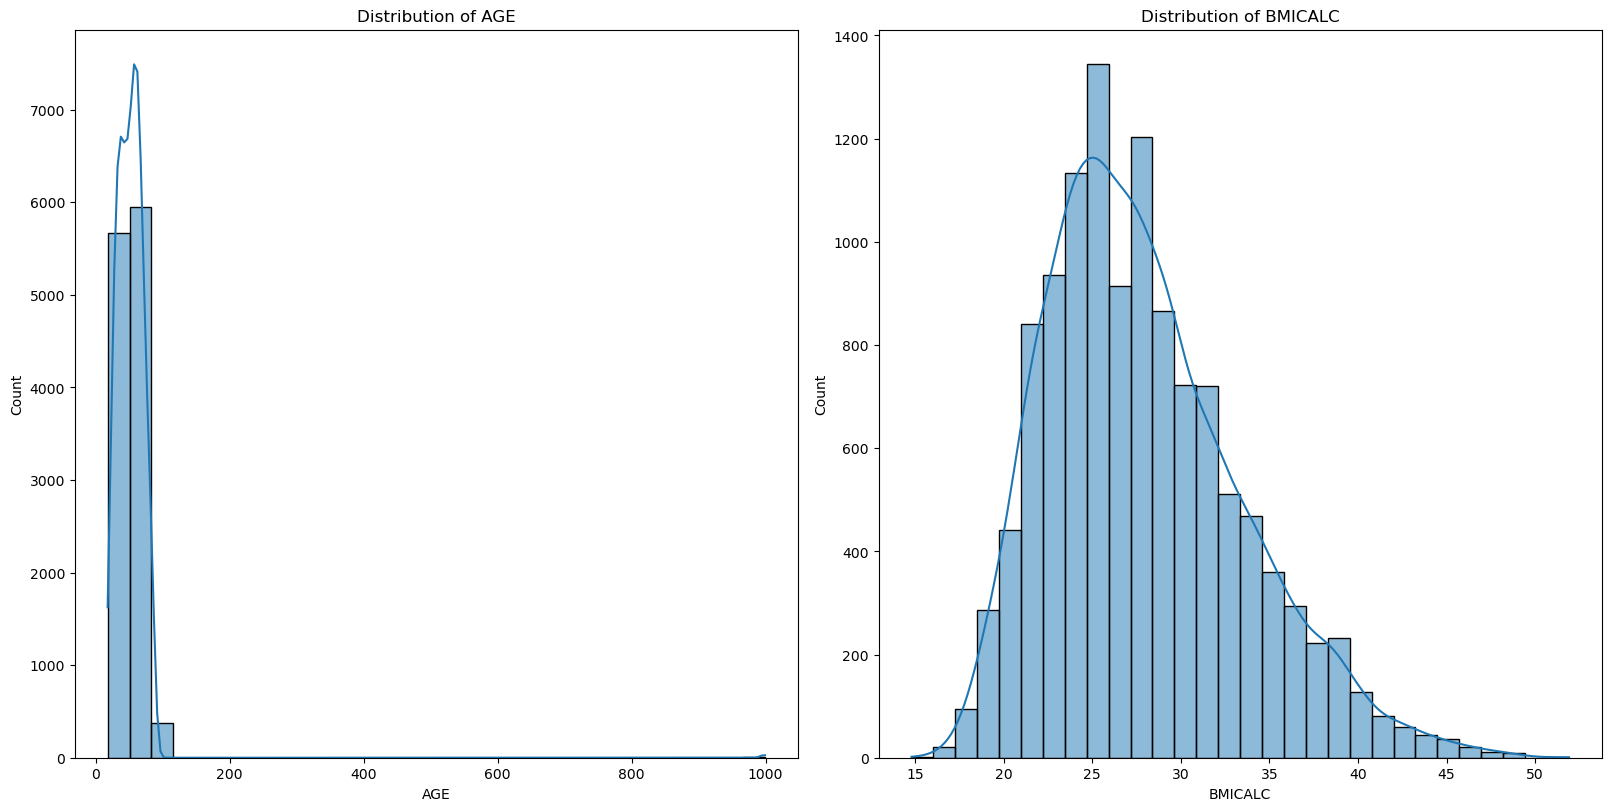

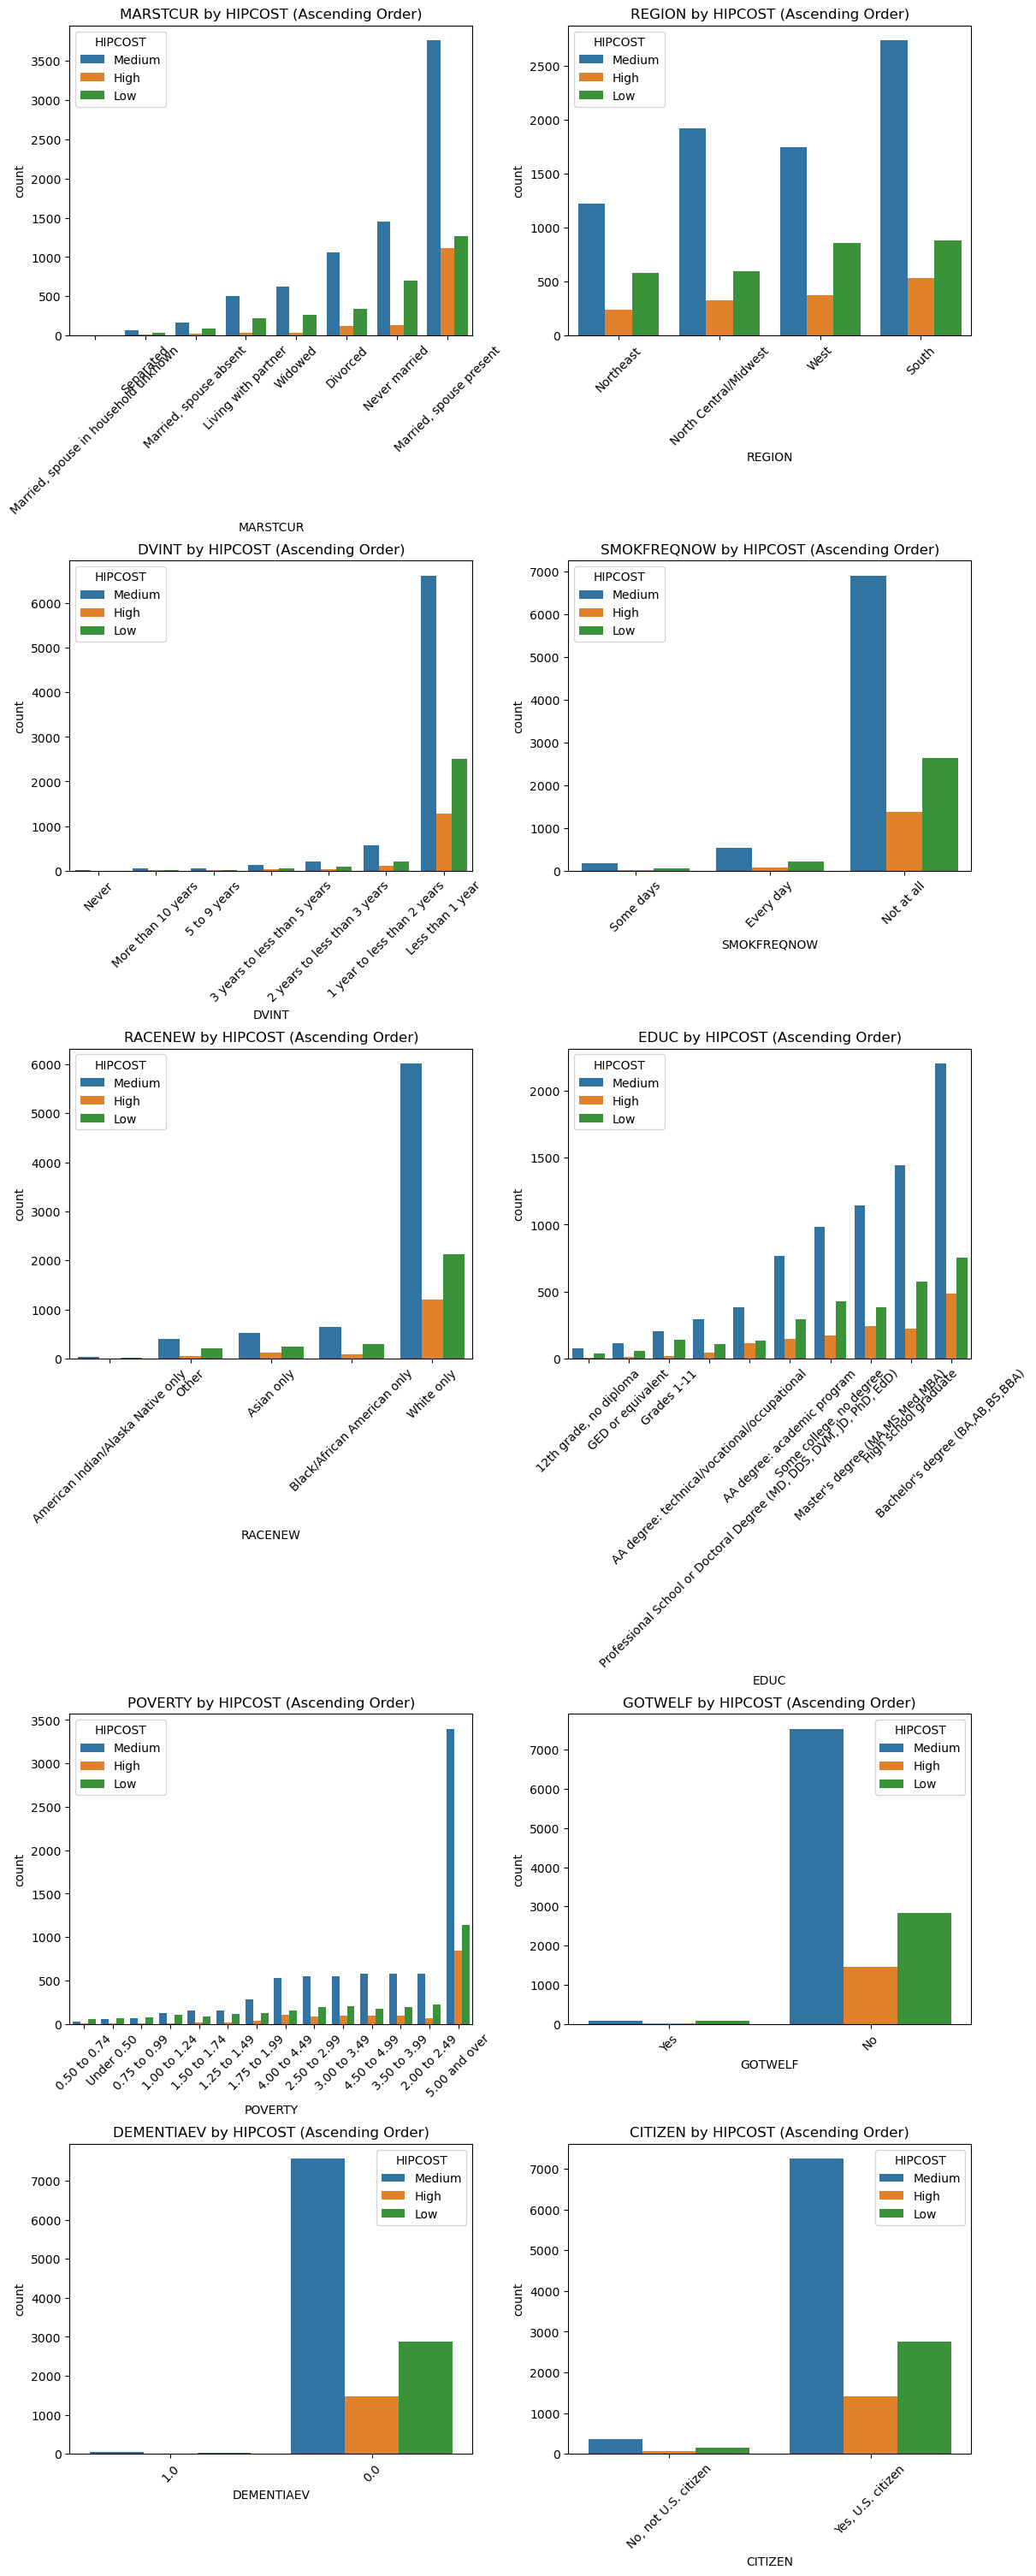

In [28]:
import math
eda_vars = ['AGE', 'BMICALC', 'MARSTCUR', 'REGION', 'DVINT',
            'SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY',
            'GOTWELF', 'DEMENTIAEV', 'CITIZEN', 'HIPCOST']

eda_df = df[eda_vars]

numerical_vars = ['AGE', 'BMICALC']
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

for i, var in enumerate(numerical_vars):
    sns.histplot(eda_df[var], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {var}")

plt.show()

categorical_vars = ['MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW',
                    'RACENEW', 'EDUC', 'POVERTY', 'GOTWELF', 'DEMENTIAEV', 'CITIZEN']

fig, axes = plt.subplots(5, 2, figsize=(2* 6, 5 * 6), constrained_layout=True)
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    sorted_categories = eda_df[var].value_counts(ascending=True).index
    sns.countplot(ax=axes[i], x=var, hue='HIPCOST', data=eda_df, order=sorted_categories)
    axes[i].set_title(f"{var} by HIPCOST (Ascending Order)")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.show()


## PART II. Building the Baseline Models

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We begin by using One Hot Encoding on the categorical variables so that they can be put into the models correctly. From there, we split the data into the training set and the test set so that we can test our model on some unused data at the end to see the accuracy. Then, we performed a grid search using cross-validation to find the optimal hyperparameters for a DecisionTreeClassifier. Based on the accuracy score from the cross validation, the Decision Tree did not work out very well. Therefore, we moved onto try a Random Forest Classiciation model.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [29]:
#store results of different models:
results = []

In [33]:
X = pd.get_dummies(df[['AGE', 'BMICALC',
                       'MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY',
                       'GOTWELF', 'DEMENTIAEV', 'CITIZEN']],
                   columns=['MARSTCUR', 'REGION','DVINT','SMOKFREQNOW', 'RACENEW', 'EDUC', 'POVERTY'],
                   dtype = int,
                   drop_first = True)

y = df['HIPCOST']
display(X.describe())
print(X.info())


,AGE,BMICALC,DEMENTIAEV,MARSTCUR_Living with partner,"MARSTCUR_Married, spouse absent","MARSTCUR_Married, spouse in household unknown","MARSTCUR_Married, spouse present",MARSTCUR_Never married,MARSTCUR_Separated,MARSTCUR_Widowed,...,POVERTY_1.50 to 1.74,POVERTY_1.75 to 1.99,POVERTY_2.00 to 2.49,POVERTY_2.50 to 2.99,POVERTY_3.00 to 3.49,POVERTY_3.50 to 3.99,POVERTY_4.00 to 4.49,POVERTY_4.50 to 4.99,POVERTY_5.00 and over,POVERTY_Under 0.50
count,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,...,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000,12005.000000
mean,52.421574,27.898026,0.007164,0.062807,0.023407,0.000083,0.511454,0.189254,0.009746,0.076968,...,0.020575,0.037234,0.072553,0.068888,0.070387,0.072220,0.065056,0.071304,0.448730,0.010496
std,33.360460,5.492185,0.084338,0.242626,0.151198,0.009127,0.499890,0.391727,0.098243,0.266552,...,0.141962,0.189344,0.259412,0.253274,0.255809,0.258862,0.246635,0.257342,0.497385,0.101913
min,18.000000,14.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,27.100000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,31.200000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,999.000000,51.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 12005 entries, 0 to 12572
Data columns (total 49 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   AGE                                                                       12005 non-null  int64  
 1   BMICALC                                                                   12005 non-null  float64
 2   GOTWELF                                                                   12005 non-null  object 
 3   DEMENTIAEV                                                                12005 non-null  float64
 4   CITIZEN                                                                   12005 non-null  object 
 5   MARSTCUR_Living with partner                                              12005 non-null  int64  
 6   MARSTCUR_Married, spouse absent                                    

In [31]:
# split data; Although random_state shouldn't be set in industry practice. We include it for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 109)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9604, 49), (2401, 49), (9604,), (2401,))

### Model 1: Decision Tree Classifier

In [32]:
param_grid = {'criterion': ['entropy'],
              'max_depth': [3, 5, 10],
              'max_leaf_nodes': [10, 15, 20],
              'class_weight': ['balanced']}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',

    n_jobs=-1
)

grid_search.fit(X_train,y_train)

ValueError: 
All the 90 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/tree/_classes.py", line 1009, in fit
    super()._fit(
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/tree/_classes.py", line 252, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py", line 645, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'No'


In [ ]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.110953  , 0.08073685, 0.08688753, 0.08740482, 0.0911016 ,
        0.08886662, 0.08947933, 0.11736946, 0.09958701]),
 'std_fit_time': array([0.02202121, 0.00499645, 0.005329  , 0.00517724, 0.00457226,
        0.00355002, 0.00363011, 0.01481068, 0.00868602]),
 'mean_score_time': array([0.01139724, 0.0074276 , 0.00683906, 0.00642388, 0.00671051,
        0.00721641, 0.00686049, 0.01100452, 0.0072963 ]),
 'std_score_time': array([0.00433429, 0.0014331 , 0.00088082, 0.00073989, 0.00104283,
        0.0015283 , 0.00132222, 0.00485531, 0.00293782]),
 'param_class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    'balanced'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy'

In [ ]:
cross_val_score(estimator=grid_search.best_estimator_,X=X_train,y=y_train,cv=10)

array([0.38125   , 0.43645833, 0.39895833, 0.359375  , 0.38333333,
       0.43020833, 0.39207508, 0.362878  , 0.38373306, 0.44838373])

In [ ]:
# get test accuracy
best_tree = grid_search.best_estimator_
y_pred_tree = best_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_tree)

In [ ]:
# get results
f1 = f1_score(y_test, y_pred_tree, average='macro')
clf_classification_report = classification_report(y_test, y_pred_tree)

# print results
print("Test score:", test_accuracy)
print("F1 score:", f1)
print("Classification report:", clf_classification_report)

# append
results.append({
    'Model': 'Decision Tree',
    'Test Score': test_accuracy,
    'Test F1 Score': f1
})

Test score: 0.4322634431012922
F1 score: 0.38562750632803544
Classification report:               precision    recall  f1-score   support

        High       0.21      0.67      0.32       300
         Low       0.32      0.26      0.29       572
      Medium       0.70      0.45      0.55      1527

    accuracy                           0.43      2399
   macro avg       0.41      0.46      0.39      2399
weighted avg       0.55      0.43      0.46      2399



##### Feature Importance & Intepretation

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We used permutation importance graph as it is more robust than built-in importance. Higher importance values indicate features that, when randomly shuffled, lead to larger decreases in model performance.

- `MARSTCUR_Married, spouse present`: highest importance. Mariage status with married could impact premiums either negatively or positively. Similar to employer-sponsored plans, a family plan through the marketplace may be cheaper per person than individual plans.
- `age`: second higest importance which means it strongly influences splits in the decision tree, significantly contributes to differentiating outcomes. Higher age (older adults) could correlate to Higher premium outcomes because the risk of developing health issues increases with age, leading insurance companies to charge more to reflect this increased potential cost of coverage.
- `EDUC_Grades 1-11 (no further detail)`: educational attainment influences predictions, possibly as a proxy for socioeconomic status or health literacy, which can affect health behaviors and insurance utilization.

This intepretation needs further investigation. While permutation importance gives us a global understanding of our model's predictions, we might be interested in local explaination. We want to understand how predictors are related to the response (positive, negative, quasi-linear, curved, interactions, etc.). We will do this through LIME in the final stage.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
from sklearn.inspection import permutation_importance

# Permutation Importance
result = permutation_importance(
    best_tree, X_test, y_test,
    n_repeats=10,
    random_state=42
)

# Create dataframe of permutation importances
perm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

NameError: name 'best_tree' is not defined

In [ ]:
perm_imp.head(10)

,feature,importance_mean,importance_std
8,"MARSTCUR_Married, spouse present",0.038891,0.006783
0,AGE,0.018591,0.007734
33,EDUC_Grades 1-11 (no further detail),0.003335,0.001087
26,RACENEW_Black/African American,0.002751,0.001239
10,MARSTCUR_Separated,0.000125,0.000591
46,POVERTY_3.50 to 3.99,0.000000,0.000000
37,"EDUC_Some college, no degree",0.000000,0.000000
27,RACENEW_Other Race and Multiple Race,0.000000,0.000000
29,EDUC_AA degree: academic program,0.000000,0.000000
30,EDUC_AA degree: technical/vocational/occupational,0.000000,0.000000


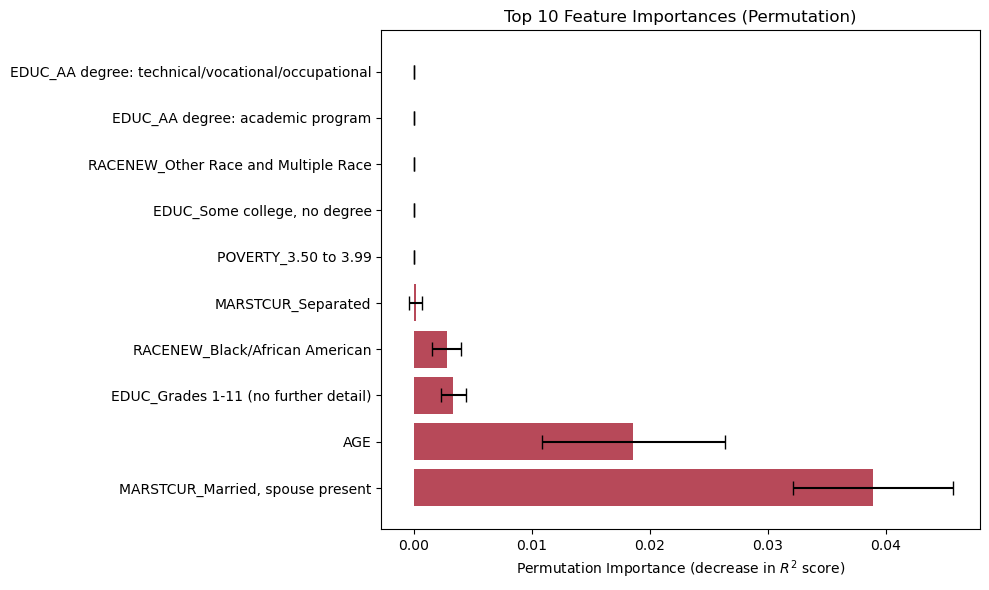

In [ ]:
# Plot top 10 features with error bars
plt.figure(figsize=(10, 6))
top_10 = perm_imp.head(10)
plt.barh(range(len(top_10)), top_10['importance_mean'],
         xerr=top_10['importance_std'], capsize=5, alpha=0.8, color='#A51C30')
plt.yticks(range(len(top_10)), top_10['feature'])
plt.title('Top 10 Feature Importances (Permutation)')
plt.xlabel('Permutation Importance (decrease in $R^2$ score)')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
outcome_classes = ['Low', 'Medium', 'High']
plot_tree(best_tree, feature_names=X_train.columns, class_names=outcome_classes, filled=True)
plt.show()

NameError: name 'best_tree' is not defined

<Figure size 1500x1000 with 0 Axes>

### Model 2: Random Forest

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Similar to the Decision Tree Model, we conducted a grid search with cross-validation to optimize hyperparameters for the `Random Forest Classifier`. After identifying the optimal parameters, we trained the model on the training dataset and evaluated its performance on the reserved testing dataset. While the Decision Tree Classifier achieved an accuracy of approximately 47%, the Random Forest Classifier improved this to 60%, demonstrating a significant enhancement in predictive performance.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
y_train.head()

6199    Medium
5845       Low
3020    Medium
8976       Low
5800       Low
Name: HIPCOST, dtype: object

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [10],
    'class_weight': ['balanced']
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state = 42)

# Set up GridSearchCV
grid_search2 = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)
grid_search2.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search2.best_params_
best_rf = grid_search2.best_estimator_

print(f"Best Parameters: {best_params}")

ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/guliranoalmuratova/micromamba/envs/cs109a/lib/python3.12/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'No'


In [ ]:
cross_val_score(estimator = grid_search2.best_estimator_, X = X_train,y = y_train, cv = 10)

array([0.60520833, 0.59479167, 0.61770833, 0.596875  , 0.61979167,
       0.61875   , 0.59854015, 0.61626694, 0.60583942, 0.61001043])

In [ ]:
# Evaluate the best model
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

In [ ]:
#get results
rf_f1 = f1_score(np.squeeze(y_test), y_pred_rf, average='macro')
rf_classification_report = classification_report(y_test, y_pred_rf)

# print results
print("F1-Score (weighted):", rf_f1)
print("Accuracy Score:", rf_accuracy)
print("Best params:", best_params)
print("Classification report:", rf_classification_report)

# append
results.append({
    'Model': 'Random Forest',
    'Parameters': best_params,
    'Test Score': rf_accuracy,
    'Test F1 Score': rf_f1
})

F1-Score (weighted): 0.35517234880609116
Accuracy Score: 0.6131721550646102
Best params: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Classification report:               precision    recall  f1-score   support

        High       0.25      0.08      0.12       300
         Low       0.37      0.13      0.19       572
      Medium       0.65      0.90      0.76      1527

    accuracy                           0.61      2399
   macro avg       0.42      0.37      0.36      2399
weighted avg       0.53      0.61      0.54      2399



##### Feature Importance & Intepretation

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

- `age`: similar intepretation as above. However, the standard deviation is extremely high. This means we need to re-evaluate and investigate the realtionship of this predictor and the response variable.
- `BMICALC (BMI)`: second highest importance. Higher BMI can be associated with increased healthcare risks, potentially leading to higher premiums due to the higher likelihood of chronic conditions.
- `SMOKFREQNOW_Not at all`: non-smokers have a substantial impact on the model, likely due to their lower risk of smoking-related health issues, which reduces premiums.

Most of the standard deviation accross features are exemtrely high, and the importance values are low. This means that our model is still unsure about the significance that each variable has on classifying the target varibale. Thus, we will need to tune our model a little more in the final step and investigate with LIME. We could try other alternatives such as Boosting or tune our RF. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
rf_result = permutation_importance(
    best_rf, X_test, y_test,
    n_repeats=10,
    random_state=42
)

# Create dataframe of permutation importances
rf_perm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': rf_result.importances_mean,
    'importance_std': rf_result.importances_std
}).sort_values('importance_mean', ascending=False)

In [ ]:
rf_perm_imp.head(10)

,feature,importance_mean,importance_std
0,AGE,0.006544,0.004097
1,BMICALC,0.003960,0.004252
22,SMOKFREQNOW_Not at all,0.003085,0.003246
15,DVINT_2 years to less than 3 years,0.002543,0.000573
6,"MARSTCUR_Married, spouse absent",0.002043,0.000435
18,DVINT_Less than 1 year,0.001667,0.001194
17,DVINT_5 to 9 years,0.001292,0.000125
26,RACENEW_Black/African American,0.001251,0.001614
40,POVERTY_1.25 to 1.49,0.001167,0.000983
43,POVERTY_2.00 to 2.49,0.001042,0.001360


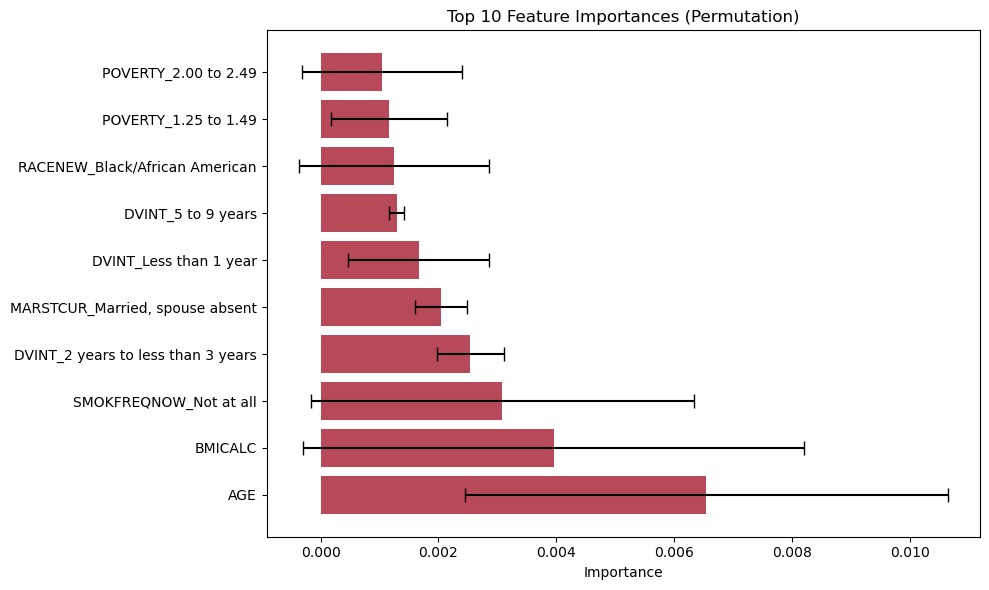

In [ ]:
# Plot top 10 features with error bars
plt.figure(figsize=(10, 6))
top_10 = rf_perm_imp.head(10)
plt.barh(range(len(top_10)), top_10['importance_mean'],
         xerr=top_10['importance_std'], capsize=5,alpha=0.8, color='#A51C30')
plt.yticks(range(len(top_10)), top_10['feature'])
plt.title('Top 10 Feature Importances (Permutation)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

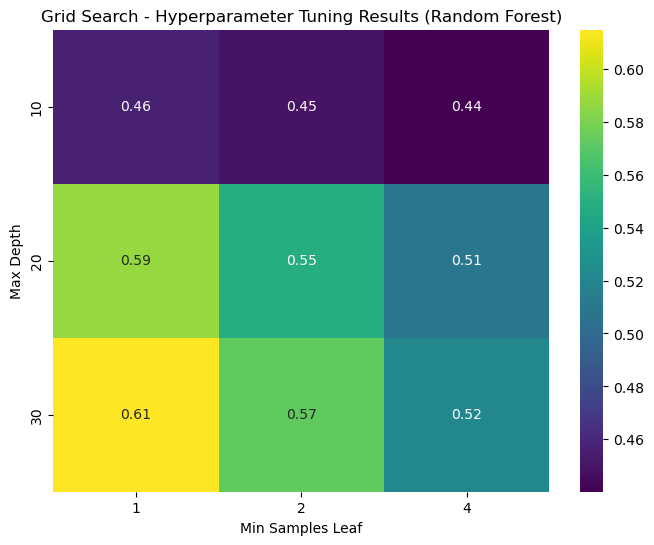

In [ ]:
results_rf = pd.DataFrame(grid_search2.cv_results_)

pivot_results = results_rf.pivot_table(index='param_max_depth',
                                   columns='param_min_samples_leaf',
                                   values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_results, annot=True, cmap="viridis", cbar=True)
plt.title("Grid Search - Hyperparameter Tuning Results (Random Forest)")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Max Depth")
plt.show()

### Interpreting the Results from Random Forest Model

In [ ]:
results_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.927638,0.040534,0.106874,0.013587,balanced,10,10,1,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.445312,0.471600,0.451277,0.463262,0.451277,0.456546,0.009523,7
1,3.157791,0.181967,0.123870,0.016138,balanced,10,10,2,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.432292,0.474205,0.439812,0.457530,0.439291,0.448626,0.015266,8
2,3.321783,0.051235,0.124865,0.011785,balanced,10,10,4,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.429167,0.460135,0.435122,0.442939,0.433559,0.440185,0.010923,9
3,5.314938,0.193818,0.400110,0.033094,balanced,20,10,1,200,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.576562,0.591975,0.585722,0.585201,0.595623,0.587017,0.006526,2
4,4.506941,0.071035,0.280123,0.057397,balanced,20,10,2,200,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.539062,0.561230,0.544554,0.549766,0.548202,0.548563,0.007326,4
5,3.853002,0.025495,0.219812,0.031460,balanced,20,10,4,200,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.496875,0.534653,0.504950,0.501824,0.503908,0.508442,0.013397,6
6,6.557555,0.473983,0.476880,0.085069,balanced,30,10,1,200,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.609375,0.619072,0.616988,0.609693,0.619072,0.614840,0.004400,1
7,5.758385,0.619772,0.484852,0.149910,balanced,30,10,2,200,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.569271,0.578426,0.568004,0.575300,0.569046,0.572009,0.004107,3
8,5.097307,0.237286,0.196503,0.086075,balanced,30,10,4,200,"{'class_weight': 'balanced', 'max_depth': 30, ...",0.505729,0.543512,0.522147,0.519020,0.516936,0.521469,0.012334,5


### Final Model Pipeline

As stated above, the Random Forest Model did significantly better than the Decision Tree Model. The test accuracy of the Random Forest Model is 60%, while the Decision Tree Classifier is 47%. Although the F1 accuracy for the RF model is slighlty lower than the DT model, the significantly higher increase in test accuracy (nearly 20p.p compared to 1p.p increase in F1 Score) still makes RF a compelling option. Thus, we use the Random Forest Model to create the Final Model pipeline, setting it up but not tuning the model just yet. Tuning this model and also experimenting with other methods like Boosting and LIME will likely improve our results.

In [ ]:
pd.DataFrame(results).iloc[:,:3]

,Model,Test Score,Test F1 Score
0,Decision Tree,0.432263,0.385628
1,Random Forest,0.613172,0.355172


In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# import pandas as pd

# cols_to_keep = ['AGE', 'BMICALC', 'MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 'RACENEW',
#                 'EDUC', 'POVERTY', 'GOTWELF', 'DEMENTIAEV', 'CITIZEN', 'HIPCOST']
# df = data[cols_to_keep].dropna()

# t1 = 1
# t2 = 7000
# df['HIPCOST'] = pd.cut(df['HIPCOST'],
#                        bins=[0, t1, t2, 50000],
#                        labels=['Low', 'Medium', 'High'],
#                        include_lowest=True).astype(str)

# X = df.drop('HIPCOST', axis=1)
# y = df['HIPCOST']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# numerical_features = ['AGE', 'BMICALC']
# categorical_features = ['MARSTCUR', 'REGION', 'DVINT', 'SMOKFREQNOW', 'RACENEW',
#                         'EDUC', 'POVERTY', 'GOTWELF', 'DEMENTIAEV', 'CITIZEN']

# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean'))
# ])

# categorical_transformer = Pipeline(steps=[￼
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# rf_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# rf_pipeline.fit(X_train, y_train)

# y_pred = rf_pipeline.predict(X_test)

# print(classification_report(y_test, y_pred))

### LIME for local interpretation

Since `Age` and `BMICALC` consistently show up as important variables, we wanted to investigate which factors are highly influential to insurance premiums for people in certain age and BMI groups. We identified four individuals (falling under Elderly/Young and High/Low BMI categories) and used LIME to uncover local explanations of insurance premiums for them.

First, we create the function to obtain LIME and plot the LIME output.

In [ ]:
# reset indices of X_train
X_train.reset_index(drop=True,inplace=True)

# create LIME
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names = X_train.columns,
                                 class_names = [0,1,2],
                                 mode = 'classification')

# create function
def get_lime(idx, title, ax=None):
    # use LIME to get local explanation
    exp = explainer.explain_instance(X_train.iloc[idx], 
                                 best_rf.predict_proba, 
                                 num_features = 10)
    
    # predict
    predicted = best_rf.predict(X_train.iloc[[idx]])[0]
    actual = y_train.iloc[idx]

    # plot
    if ax is not None:
        features = [f[0] for f in exp.as_list()]
        weights = [f[1] for f in exp.as_list()]
        colors = ['green' if weight > 0 else 'red' for weight in weights]
        ax.barh(features, weights, color=colors)
        ax.set_title(f'{title}\nPredicted: {predicted}, Actual: {actual}')
        ax.set_xlabel("Weight")
        ax.invert_yaxis()
    else:
        fig = exp.as_pyplot_figure()
        plt.title(f'{title}\nPredicted: {predicted}, Actual: {actual}')
        plt.show()

Take a peek at information of those four people...

In [ ]:
# indices of interest
indices = [60,    # high BMI, elderly
           636,   # high BMI, young
           42,    # normal BMI, elderly
           3869]  # normal BMI, young

# set title
titles = ["Explanation for High BMI, Elderly", "Explanation for High BMI, Young", 
          "Explanation for Normal BMI, Elderly", "Normal BMI, Young"]

X_train.iloc[indices]

,AGE,BMICALC,GOTWELF,DEMENTIAEV,CITIZEN,MARSTCUR_Living with partner,"MARSTCUR_Married, spouse absent","MARSTCUR_Married, spouse in household unknown","MARSTCUR_Married, spouse present",MARSTCUR_Never Married,...,POVERTY_1.50 to 1.74,POVERTY_1.75 to 1.99,POVERTY_2.00 to 2.49,POVERTY_2.50 to 2.99,POVERTY_3.00 to 3.49,POVERTY_3.50 to 3.99,POVERTY_4.00 to 4.49,POVERTY_4.50 to 4.99,POVERTY_5.00 and over,POVERTY_Under 0.50
60,62.0,44.3,1.0,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
636,28.0,41.6,1.0,0.0,1.0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
42,75.0,23.6,1.0,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3869,20.0,22.0,1.0,0.0,1.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Visualize LIME outputs!

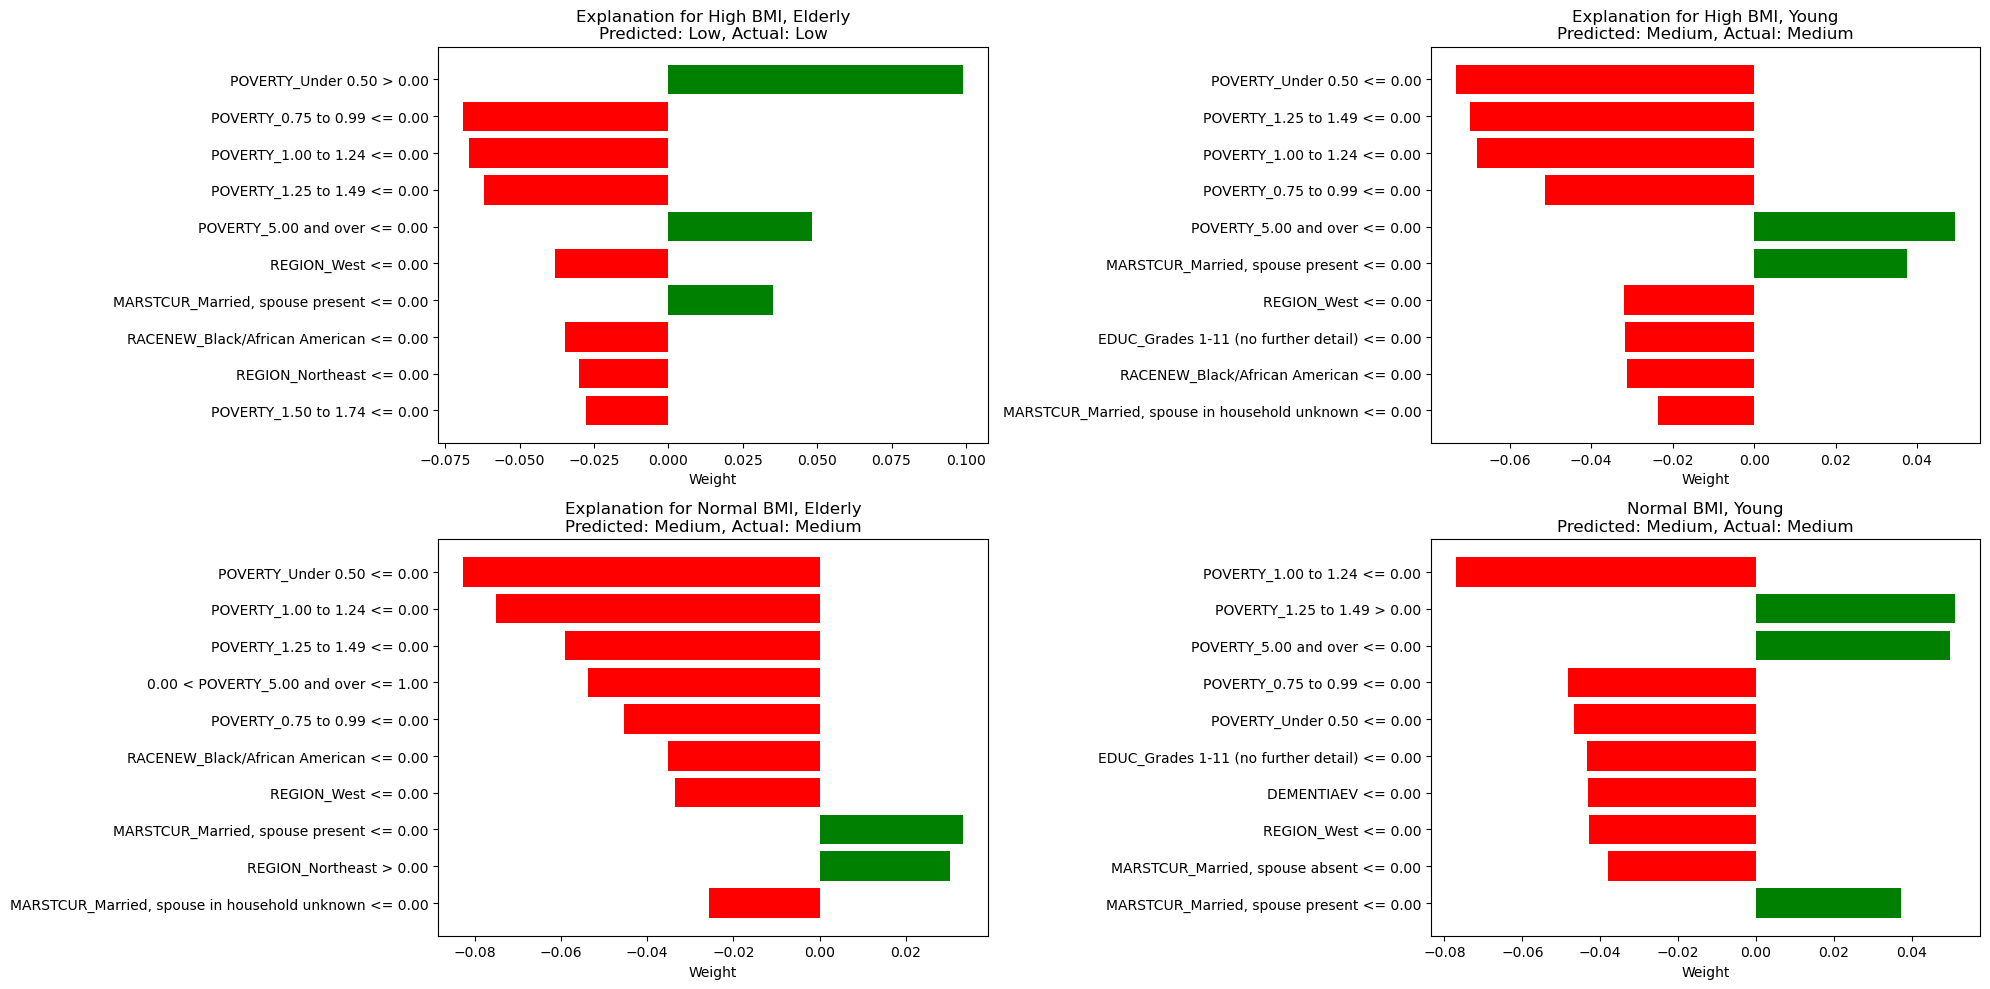

In [ ]:
# create axes
fig, axes = plt.subplots(2, 2, figsize=(20, 10))  # Adjust size as needed
axes = axes.flatten()  # Flatten to iterate easily

# plot
for idx, title, ax in zip(indices, titles, axes):
    get_lime(idx, title, ax=ax)

plt.tight_layout()
plt.show()

Although LIME outputs do vary from prediction to prediction (i.e. those outputs might not hold for other subjects within similar age/BMI range), we do gain some valuable insights by zooming into the local level. 

- Indicators related to income brackets are consistently influential in predicting the final premiums. For example, `POVERTY_Under 0.50` (meaning earning under 0.5 times the poverty line) shows up as important among all four subjects. The high BMI, elderly person has `POVERTY_Under 0.50` = 1 (meaning that they earn under 0.5 times the poverty line); the green bar means that being poor makes them *more* likely to pay nothing for premiums (i.e. belonging to class `Low`). 
- `Married, spouse present` = 0 contributes slightly to the classification across all four individuals. The contribution is marginally positive; perhaps this means that

## PART III. Boosting Random Forest model

### AdaBoost

#### AdaBoost for 

np.int64(45)

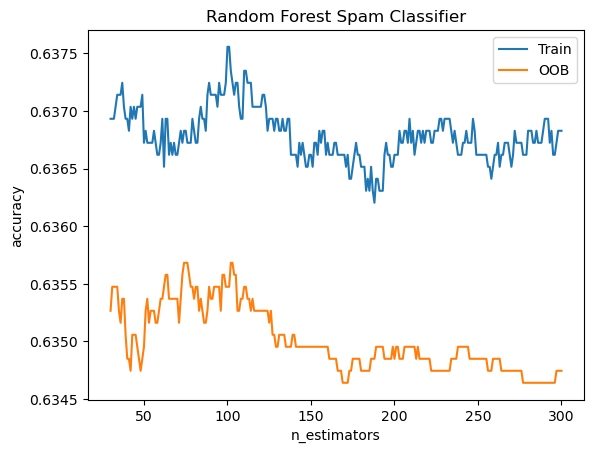

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# create train/val split for hyperparameter tuning
X_train80, X_val, y_train80, y_val = train_test_split(X_train, y_train,
                                                      train_size=.8,
                                                      random_state=0,
                                                      stratify=y_train)

# track train and OOB scores
train_scores = []
oob_scores = []

# set untuned model parameters
max_features = 'sqrt'
max_depth = 5

# instantiate a single RandomForestClassifier object
rf = RandomForestClassifier(n_estimators=1, # n_estimators will be overwritten in loop
                            max_features='sqrt',
                            max_depth=5,
                            oob_score=True,
                            warm_start=True,
                            random_state=0)
max_estimators = 300
n_estimator_range = range(30, max_estimators+1)

# loop through different values of n_estimators
for n in n_estimator_range:

    # set n_estimators and fit
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    # get train and OOB scores
    train_scores.append(rf.score(X_train, y_train))
    oob_scores.append(rf.oob_score_)

# create the trace plot
plt.plot(n_estimator_range, train_scores, label='Train')
plt.plot(n_estimator_range, oob_scores, label='OOB')
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.legend()
plt.title("Random Forest Spam Classifier");

# Best num estimators based on OOB
rf_best_n_estimators = np.argmax(oob_scores)+1
rf_best_n_estimators

#### AdaBoost for Decision Tree

/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


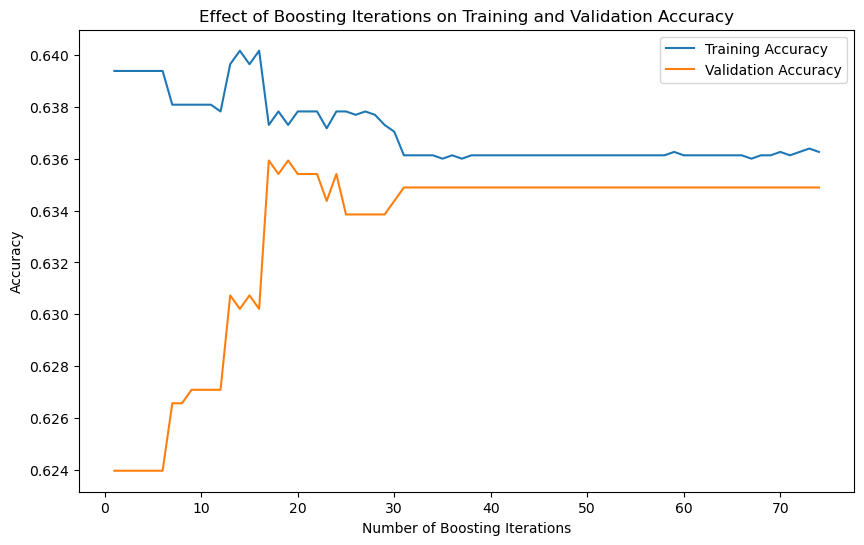

In [ ]:
# base tree
base_learner = DecisionTreeClassifier(max_depth=3, random_state=0)

# boost
adaboost_model = AdaBoostClassifier(
    estimator=base_learner,
    n_estimators=74,
    learning_rate=0.05,
    algorithm="SAMME",
    random_state=0)
adaboost_model.fit(X_train80, y_train80)

# get train/val scores
train_accuracies = list(adaboost_model.staged_score(X_train80, y_train80))
val_accuracies = list(adaboost_model.staged_score(X_val, y_val))

# plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 75), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 75), val_accuracies, label="Validation Accuracy")
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Accuracy")
plt.title("Effect of Boosting Iterations on Training and Validation Accuracy")
plt.legend()
plt.show()

/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/c

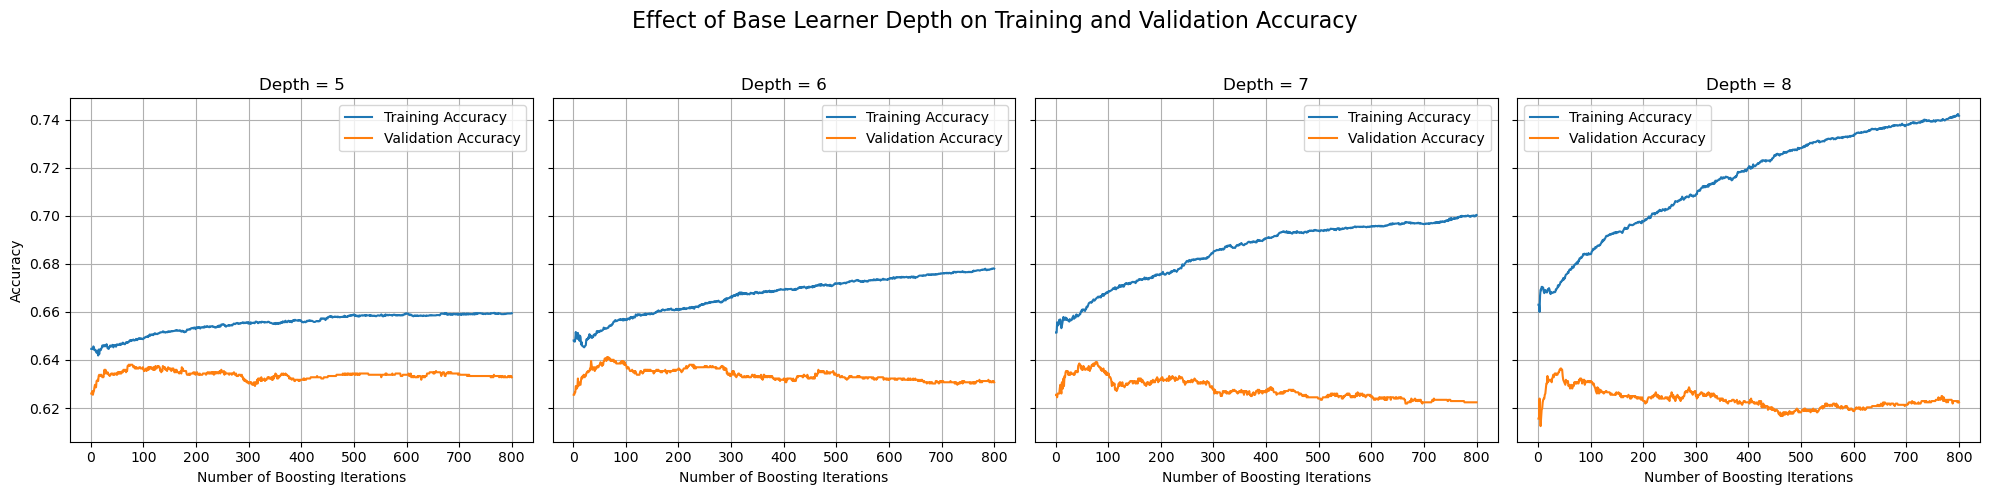

In [ ]:
# your code here
depths = [5, 6, 7, 8]
learning_rate = 0.05
n_estimators = 800

fig, axes = plt.subplots(1, len(depths), figsize=(20, 5), sharey=True)

for i, depth in enumerate(depths):
    base_learner = DecisionTreeClassifier(max_depth=depth, random_state=0)
    adaboost_model = AdaBoostClassifier(
        estimator=base_learner,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm="SAMME",
        random_state=0
    )
    adaboost_model.fit(X_train80, y_train80)

    # Get staged accuracies
    train_accuracies = list(adaboost_model.staged_score(X_train80, y_train80))
    val_accuracies = list(adaboost_model.staged_score(X_val, y_val))

    # Plot accuracies
    axes[i].plot(range(1, n_estimators + 1), train_accuracies, label="Training Accuracy")
    axes[i].plot(range(1, n_estimators + 1), val_accuracies, label="Validation Accuracy")
    axes[i].set_title(f"Depth = {depth}")
    axes[i].set_xlabel("Number of Boosting Iterations")
    if i == 0:
        axes[i].set_ylabel("Accuracy")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Effect of Base Learner Depth on Training and Validation Accuracy", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# your code here
best_iterations = {}
best_accuracies = {}

for depth in depths:
    base_learner = DecisionTreeClassifier(max_depth=depth, random_state=0)
    adaboost_model = AdaBoostClassifier(
        estimator=base_learner,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm="SAMME.R",
        random_state=0
    )
    adaboost_model.fit(X_train80, y_train80)
    val_accuracies = list(adaboost_model.staged_score(X_val, y_val))

    best_idx = np.argmax(val_accuracies)
    best_iterations[depth] = best_idx + 1  
    best_accuracies[depth] = val_accuracies[best_idx]

for depth in depths:
    print(f"Depth {depth}: Best Validation Accuracy = {best_accuracies[depth]:.4f} 
    at {best_iterations[depth]} iterations")

# your code here
final_base_learner = DecisionTreeClassifier(max_depth=5, random_state=0)
final_adaboost = AdaBoostClassifier(
    estimator=final_base_learner,
    n_estimators=74,  
    learning_rate=0.05,
    algorithm="SAMME",
    random_state=0)


final_adaboost.fit(X_train, y_train)
ada_train_acc = final_adaboost.score(X_train, y_train)
ada_test_acc = final_adaboost.score(X_test, y_test)
print(ada_train_acc, ada_test_acc)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(final_adaboost, X, y, cv=cv)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/cs109a/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/lpvu/Y/envs/c

Depth 5: Best Validation Accuracy = 0.6375 at 23 iterations
Depth 6: Best Validation Accuracy = 0.6328 at 6 iterations
Depth 7: Best Validation Accuracy = 0.6255 at 1 iterations
Depth 8: Best Validation Accuracy = 0.6167 at 266 iterations
0.643705710712797 0.6402667778240934
Cross-validation scores: [0.63109629 0.64235098 0.63818258 0.63818258 0.63401417]
Mean accuracy: 0.6367653188828679


### XGBoost

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")